In [1]:
import os
import openai

In [ ]:
#Group
OPENAI_KEY = "..."

openai.api_key = OPENAI_KEY

endpoint = "https://api.openai.com/v1/engines/davinci-codex/completions"

# DATA PREPROCESS&ANALYSIS

In [3]:
import json
import tiktoken
import numpy as np
from collections import defaultdict

In [9]:
#Format

# Read original data
with open("cikm18_valid.jsonl", "r") as f:
    lines = f.readlines()

new_lines = []

for line in lines:
    data = json.loads(line)
    conversations = data.get("conversations", [])
    
    messages_list = []
    for convo in conversations:
        role = "user" if convo["from"] == "human" else "assistant"
        messages_list.append({"role": role, "content": convo["value"]})
    
    new_lines.append({"messages": messages_list})

# Save into new file
with open("transformed_cikm18_valid.jsonl", "w") as f:
    for item in new_lines:
        f.write(json.dumps(item) + "\n")

In [13]:
#Split

data_path = "./acl18_train.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Keep only the first n examples
subset = dataset[:100]

# Save the subset to another jsonl file
output_path = "./sub.jsonl"
with open(output_path, 'w', encoding='utf-8') as f:
    for item in subset:
        f.write(json.dumps(item) + "\n")

print(f"Subset saved to: {output_path}")

Subset saved to: ./transformed_cikm18_train.jsonl


In [22]:
original_data_path = "./acl18_train.jsonl"

# Load the dataset
with open(original_data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["conversations"]:
    print(message)

Num examples: 20781
First example:
{'from': 'human', 'value': 'By reviewing the data and tweets, can we predict if the closing price of $csco will go upwards or downwards at 2014-01-02? Please indicate either Rise or Fall.\nContext: date,open,high,low,close,adj-close,inc-5,inc-10,inc-15,inc-20,inc-25,inc-30\n2013-12-17,-0.9,1.0,-1.1,1.2,1.2,-1.3,-0.0,0.4,0.9,2.1,3.6\n2013-12-18,-0.6,0.2,-2.3,0.4,0.4,-1.6,-0.5,-0.0,0.4,1.2,2.9\n2013-12-19,0.0,0.0,-1.4,0.3,0.3,-1.4,-0.8,-0.4,0.0,0.3,2.2\n2013-12-20,-0.3,0.6,-0.8,0.3,0.3,-0.8,-1.2,-0.7,-0.4,-0.0,1.6\n2013-12-23,-1.5,0.3,-1.6,2.1,2.1,-2.0,-3.0,-2.6,-2.4,-2.1,-0.8\n2013-12-24,-1.1,0.3,-1.2,0.6,0.6,-1.8,-3.3,-3.0,-2.8,-2.5,-1.6\n2013-12-26,-0.4,0.4,-0.4,0.5,0.5,-1.6,-3.4,-3.3,-3.2,-3.0,-2.4\n2013-12-27,-1.0,0.1,-1.1,1.0,1.0,-1.7,-3.7,-4.0,-4.0,-3.8,-3.6\n2013-12-30,-1.1,0.4,-1.1,1.0,1.0,-1.7,-3.8,-4.7,-4.7,-4.6,-4.5\n2013-12-31,-0.8,0.2,-1.2,0.8,0.8,-1.7,-3.8,-5.1,-5.2,-5.2,-5.1\n\n2014-01-01: weekly s&amp;p500 #stocks trend $btu $dhi $jcp $

In [15]:
data_path = "./transformed_cikm18_train.jsonl"

# Load the dataset
with open(data_path, 'r', encoding='utf-8') as f:
    dataset = [json.loads(line) for line in f]

# Initial dataset stats
print("Num examples:", len(dataset))
print("First example:")
for message in dataset[0]["messages"]:
    print(message)

Num examples: 3396
First example:
{'role': 'user', 'content': 'Analyze the information and social media posts to determine if the closing price of $c will ascend or descend at 2017-01-18. Please respond with either Rise or Fall.\nContext: date,open,high,low,close,adj-close,inc-5,inc-10,inc-15,inc-20,inc-25,inc-30\n2017-01-03,0.1,0.8,-1.4,2.0,2.0,-0.8,-0.4,-0.8,-1.3,-2.5,-3.3\n2017-01-04,-1.2,0.4,-1.3,1.4,1.4,-2.0,-1.5,-1.9,-2.2,-3.4,-4.3\n2017-01-05,1.0,1.8,-0.7,-1.7,-1.7,-0.2,0.2,-0.1,-0.3,-1.4,-2.3\n2017-01-06,0.2,0.5,-0.8,0.3,0.3,-0.1,-0.2,-0.3,-0.5,-1.4,-2.4\n2017-01-09,-0.1,0.7,-0.9,-0.5,-0.5,0.7,0.3,0.2,0.0,-0.7,-1.7\n2017-01-10,-0.0,1.0,-0.5,0.0,0.0,0.5,0.2,0.3,0.0,-0.4,-1.5\n2017-01-11,-0.5,0.1,-1.2,-0.4,-0.4,0.5,0.4,0.8,0.5,0.2,-0.8\n2017-01-12,0.5,1.0,-0.8,-1.2,-1.2,1.4,1.5,1.8,1.7,1.5,0.6\n2017-01-13,-0.3,1.2,-0.4,0.7,0.7,0.4,0.9,1.0,1.0,0.9,0.1\n2017-01-17,1.1,1.6,-0.6,-2.1,-2.1,1.9,2.9,2.9,3.0,2.9,2.3\n\n2017-01-03: citigroup inc. $c shares gap up after analyst upgrade |rt

In [11]:
# Format error checks
format_errors = defaultdict(int)

for ex in dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1
        continue
        
    messages = ex.get("messages", None)
    if not messages:
        format_errors["missing_messages_list"] += 1
        continue
        
    for message in messages:
        if "role" not in message or "content" not in message:
            format_errors["message_missing_key"] += 1
        
        if any(k not in ("role", "content", "name") for k in message):
            format_errors["message_unrecognized_key"] += 1
        
        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1
            
        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1
    
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] += 1

if format_errors:
    print("Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("No errors found")

No errors found


In [12]:
encoding = tiktoken.get_encoding("cl100k_base")

# not exact!
# simplified from https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3
    return num_tokens

def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"]))
    return num_tokens

def print_distribution(values, name):
    print(f"\n#### Distribution of {name}:")
    print(f"min / max: {min(values)}, {max(values)}")
    print(f"mean / median: {np.mean(values)}, {np.median(values)}")
    print(f"p5 / p95: {np.quantile(values, 0.1)}, {np.quantile(values, 0.9)}")

In [13]:
# Warnings and tokens counts
n_missing_system = 0
n_missing_user = 0
n_messages = []
convo_lens = []
assistant_message_lens = []

for ex in dataset:
    messages = ex["messages"]
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1
    n_messages.append(len(messages))
    convo_lens.append(num_tokens_from_messages(messages))
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))
    
print("Num examples missing system message:", n_missing_system)
print("Num examples missing user message:", n_missing_user)
print_distribution(n_messages, "num_messages_per_example")
print_distribution(convo_lens, "num_total_tokens_per_example")
print_distribution(assistant_message_lens, "num_assistant_tokens_per_example")
n_too_long = sum(l > 4096 for l in convo_lens)
print(f"\n{n_too_long} examples may be over the 4096 token limit, they will be truncated during fine-tuning")

Num examples missing system message: 1143
Num examples missing user message: 0

#### Distribution of num_messages_per_example:
min / max: 2, 2
mean / median: 2.0, 2.0
p5 / p95: 2.0, 2.0

#### Distribution of num_total_tokens_per_example:
min / max: 1186, 1872
mean / median: 1511.7681539807525, 1517.0
p5 / p95: 1357.4, 1655.0

#### Distribution of num_assistant_tokens_per_example:
min / max: 1, 2
mean / median: 1.5809273840769904, 2.0
p5 / p95: 1.0, 2.0

0 examples may be over the 4096 token limit, they will be truncated during fine-tuning


In [14]:
# Pricing and default n_epochs estimate
MAX_TOKENS_PER_EXAMPLE = 4096

TARGET_EPOCHS = 3
MIN_TARGET_EXAMPLES = 100
MAX_TARGET_EXAMPLES = 25000
MIN_DEFAULT_EPOCHS = 1
MAX_DEFAULT_EPOCHS = 25

n_epochs = TARGET_EPOCHS
n_train_examples = len(dataset)
if n_train_examples * TARGET_EPOCHS < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, MIN_TARGET_EXAMPLES // n_train_examples)
elif n_train_examples * TARGET_EPOCHS > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, MAX_TARGET_EXAMPLES // n_train_examples)

n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in convo_lens)
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~1727951 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~5183853 tokens


In [68]:
cost = ((n_epochs * n_billing_tokens_in_dataset)/1000)*0.008
print(cost)

130.693656


# MODEL TRAINING

In [10]:
openai.Model.list()

<OpenAIObject list at 0x15ce6205d30> JSON: {
  "object": "list",
  "data": [
    {
      "id": "text-search-babbage-doc-001",
      "object": "model",
      "created": 1651172509,
      "owned_by": "openai-dev",
      "permission": [
        {
          "id": "modelperm-s9n5HnzbtVn7kNc5TIZWiCFS",
          "object": "model_permission",
          "created": 1695933794,
          "allow_create_engine": false,
          "allow_sampling": true,
          "allow_logprobs": true,
          "allow_search_indices": true,
          "allow_view": true,
          "allow_fine_tuning": false,
          "organization": "*",
          "group": null,
          "is_blocking": false
        }
      ],
      "root": "text-search-babbage-doc-001",
      "parent": null
    },
    {
      "id": "curie-search-query",
      "object": "model",
      "created": 1651172509,
      "owned_by": "openai-dev",
      "permission": [
        {
          "id": "modelperm-8aqdyZaKtD3MD831mGbqh1MD",
          "object": "m

In [73]:
openai.File.list()

<OpenAIObject list at 0x15ce5ff37d0> JSON: {
  "object": "list",
  "data": [
    {
      "object": "file",
      "id": "file-4OG0dNaNZFdwF88m2ZOzlNZP",
      "purpose": "fine-tune",
      "filename": "Final_transformed_train.jsonl",
      "bytes": 10211860,
      "created_at": 1697119168,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-VQr8J027ePK1uEKIDDnKdl8Z",
      "purpose": "fine-tune",
      "filename": "Final_transformed_valid.jsonl",
      "bytes": 766970,
      "created_at": 1697121672,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-b72DqGlGXsLcyNQLWgh1D7NX",
      "purpose": "fine-tune-results",
      "filename": "step_metrics.csv",
      "bytes": 35234,
      "created_at": 1697127928,
      "status": "processed",
      "status_details": null
    },
    {
      "object": "file",
      "id": "file-f8jDLJRjy1CEYHRD7alvryuL",
      "purpose": "fine-t

In [51]:
#openai.File.delete("file-YGrbEoiq9QlvpQBWlIXK3miS")

<File file id=file-YGrbEoiq9QlvpQBWlIXK3miS at 0x15ce62f2d50> JSON: {
  "object": "file",
  "id": "file-YGrbEoiq9QlvpQBWlIXK3miS",
  "deleted": true
}

In [30]:
#!openai tools fine_tunes.prepare_data -f transformed_train.jsonl

In [48]:
openai.File.create(
    file=open("./transformed_cikm18_valid.jsonl", "rb"),
    purpose='fine-tune',
    user_provided_filename="transformed_cikm18_valid.jsonl"
)

<File file id=file-mOipXk6BKLm15Pqh1G41uVCI at 0x15ce5ff3a10> JSON: {
  "object": "file",
  "id": "file-mOipXk6BKLm15Pqh1G41uVCI",
  "purpose": "fine-tune",
  "filename": "transformed_cikm18_valid.jsonl",
  "bytes": 1713655,
  "created_at": 1697217825,
  "status": "uploaded",
  "status_details": null
}

In [74]:
openai.FineTuningJob.create(
    training_file="file-f8jDLJRjy1CEYHRD7alvryuL", 
    validation_file="file-mOipXk6BKLm15Pqh1G41uVCI",
    model="ft:gpt-3.5-turbo-0613:personal:final:88sn0w7T",
    hyperparameters={"n_epochs":2},
    suffix="FINAL2")

<FineTuningJob fine_tuning.job id=ftjob-1SEvgROG3MmRUjN0LEkJsKC3 at 0x15cf7e43230> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-1SEvgROG3MmRUjN0LEkJsKC3",
  "model": "ft:gpt-3.5-turbo-0613:personal:final:88sn0w7T",
  "created_at": 1697219497,
  "finished_at": null,
  "fine_tuned_model": null,
  "organization_id": "org-72fGWj0t8ALGxoLP3RnIyEhe",
  "result_files": [],
  "status": "validating_files",
  "validation_file": "file-mOipXk6BKLm15Pqh1G41uVCI",
  "training_file": "file-f8jDLJRjy1CEYHRD7alvryuL",
  "hyperparameters": {
    "n_epochs": 2
  },
  "trained_tokens": null,
  "error": null
}

In [4]:
openai.FineTuningJob.retrieve("ftjob-1SEvgROG3MmRUjN0LEkJsKC3")

<FineTuningJob fine_tuning.job id=ftjob-1SEvgROG3MmRUjN0LEkJsKC3 at 0x25eb6a091f0> JSON: {
  "object": "fine_tuning.job",
  "id": "ftjob-1SEvgROG3MmRUjN0LEkJsKC3",
  "model": "ft:gpt-3.5-turbo-0613:personal:final:88sn0w7T",
  "created_at": 1697219497,
  "finished_at": 1697235091,
  "fine_tuned_model": "ft:gpt-3.5-turbo-0613:personal:final2:89KfUCFl",
  "organization_id": "org-72fGWj0t8ALGxoLP3RnIyEhe",
  "result_files": [
    "file-xsELqeUP30vIF6QfUIYneovk"
  ],
  "status": "succeeded",
  "validation_file": "file-mOipXk6BKLm15Pqh1G41uVCI",
  "training_file": "file-f8jDLJRjy1CEYHRD7alvryuL",
  "hyperparameters": {
    "n_epochs": 2
  },
  "trained_tokens": 10877554,
  "error": null
}

In [76]:
#openai.FineTuningJob.cancel("ftjob-a1R9OX1eDTSO4NJ5P9iTIYWX")

In [5]:
openai.FineTuningJob.list_events(id="ftjob-1SEvgROG3MmRUjN0LEkJsKC3", limit=20)

<OpenAIObject list at 0x25eb76b3170> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-i9i0a7fXqikBwRMJqUdsi95K",
      "created_at": 1697235095,
      "level": "info",
      "message": "The job has successfully completed",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-WYP7U5Dicr1nGx6mFbCWD4so",
      "created_at": 1697235092,
      "level": "info",
      "message": "New fine-tuned model created: ft:gpt-3.5-turbo-0613:personal:final2:89KfUCFl",
      "data": {},
      "type": "message"
    },
    {
      "object": "fine_tuning.job.event",
      "id": "ftevent-NQadHqJVnxFKK6qWFzShLntH",
      "created_at": 1697234854,
      "level": "info",
      "message": "Step 1601/1698: training loss=0.16, validation loss=0.30",
      "data": {
        "step": 1601,
        "train_loss": 0.16169043723493814,
        "valid_loss": 0.29957151412963867,
        "train_mean_to

In [22]:
#Result1:file-b72DqGlGXsLcyNQLWgh1D7NX
#Result2:file-xsELqeUP30vIF6QfUIYneovk

content = openai.File.download("file-b72DqGlGXsLcyNQLWgh1D7NX")
content

b'step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy\n1,3.11709,0.54167,3.28847,0.36364\n2,3.2391,0.46078,,\n3,3.24339,0.58333,,\n4,4.46964,0.41667,,\n5,3.10036,0.51905,,\n6,3.21543,0.46429,,\n7,3.17571,0.52174,,\n8,3.37909,0.55,,\n9,2.98069,0.41667,,\n10,3.12263,0.52273,,\n11,2.71744,0.59804,,\n12,2.58423,0.53947,,\n13,3.31015,0.41667,,\n14,2.90264,0.55769,,\n15,2.52576,0.57778,,\n16,2.67466,0.46296,,\n17,2.33605,0.44444,,\n18,2.11798,0.59821,,\n19,1.90783,0.62698,,\n20,1.69707,0.56818,,\n21,1.85193,0.54167,,\n22,1.28026,0.61111,,\n23,1.78034,0.47619,,\n24,1.02827,0.58333,,\n25,0.96279,0.6627,,\n26,0.91508,0.55,,\n27,0.7241,0.55556,,\n28,0.6171,0.5,,\n29,0.46782,0.71364,,\n30,0.30257,0.875,,\n31,0.29123,0.80208,,\n32,0.32578,0.74242,,\n33,0.23085,0.91288,,\n34,0.3515,0.77451,,\n35,0.25862,0.80833,,\n36,0.30207,0.74176,,\n37,0.28871,0.81319,,\n38,0.19705,0.77778,,\n39,0.2389,0.77778,,\n40,0.17361,0.95455,,\n41,0.20595,0.86364,,\n42,0.16214,0.89683,,\n43,0.27206,0.72619

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import io

data = io.StringIO(content.decode('utf-8'))
df = pd.read_csv(data, sep=",")
#df.to_csv('Result.csv')
df[50:100]

,step,train_loss,train_accuracy,valid_loss,valid_mean_token_accuracy
50,51,0.20430,0.86058,NaN,NaN
51,52,0.19880,0.94118,NaN,NaN
52,53,0.15517,0.96429,NaN,NaN
53,54,0.17801,0.91667,NaN,NaN
54,55,0.17416,0.90417,NaN,NaN
55,56,0.18674,0.93939,NaN,NaN
56,57,0.21907,0.82222,NaN,NaN
57,58,0.19806,0.91667,NaN,NaN
58,59,0.24771,0.91176,NaN,NaN
59,60,0.18717,0.88095,NaN,NaN


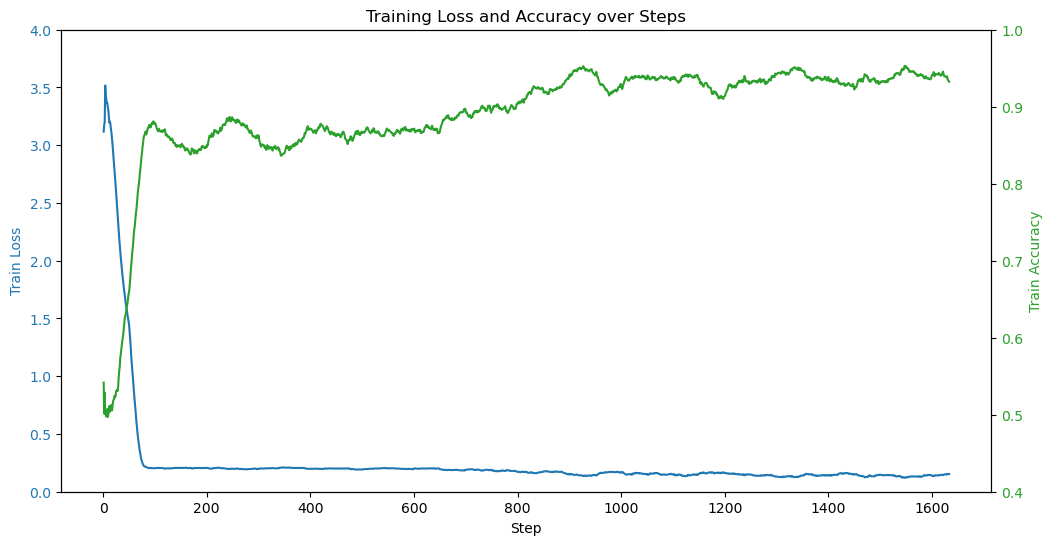

In [25]:
def moving_average(data, window_size):
    """Compute moving average of a list."""
    cumsum = [0]
    moving_av = []
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i >= window_size:
            moving_ave = (cumsum[i] - cumsum[i-window_size]) / window_size
            moving_av.append(moving_ave)
        else:
            moving_av.append(cumsum[i] / i)
    return moving_av

smoothed_train_loss = moving_average(df['train_loss'], window_size=50)
smoothed_train_accuracy = moving_average(df['train_accuracy'], window_size=50)

# Plotting smoothed training loss and training accuracy
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting smoothed train loss
ax1.set_xlabel('Step')
ax1.set_ylabel('Train Loss', color='tab:blue')
ax1.plot(df['step'], smoothed_train_loss, color='tab:blue', label='Smoothed Train Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 4)

# Using twinx() to create a second y-axis for the smoothed training accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Train Accuracy', color='tab:green')
ax2.plot(df['step'], smoothed_train_accuracy, color='tab:green', label='Smoothed Train Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.set_ylim(0.4, 1)

# Display the plot
plt.title('Training Loss and Accuracy over Steps')
plt.savefig("result1.png")
plt.show()

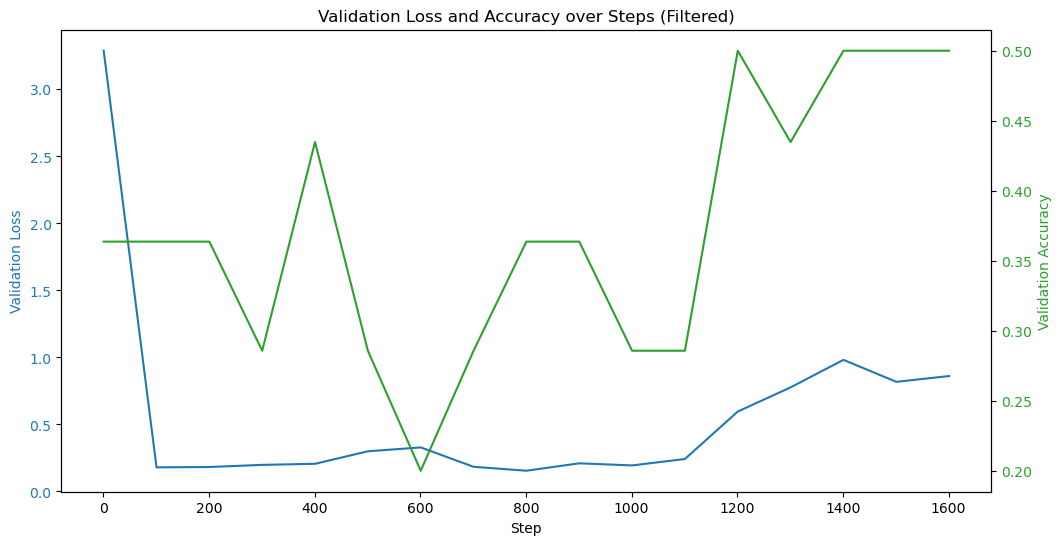

In [29]:
# Filtering out rows where 'valid_loss' or 'valid_mean_token_accuracy' are NaN
filtered_df = df.dropna(subset=['valid_loss', 'valid_mean_token_accuracy'])

# Plotting validation loss and validation accuracy for the filtered data
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting validation loss
ax1.set_xlabel('Step')
ax1.set_ylabel('Validation Loss', color='tab:blue')
ax1.plot(filtered_df['step'], filtered_df['valid_loss'], color='tab:blue', label='Validation Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Using twinx() to create a second y-axis for the validation accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Validation Accuracy', color='tab:green')
ax2.plot(filtered_df['step'], filtered_df['valid_mean_token_accuracy'], color='tab:green', label='Validation Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:green')

# Display the plot
plt.title('Validation Loss and Accuracy over Steps (Filtered)')
plt.show()


In [5]:
# Resetting the counters
total_count = 0
correct_count = 0

# Open the file and process the data
with open("./test/gpt3.5turbo_bigdata22.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        data = json.loads(line)
        
        # Check if "type" key exists and if the event type is "match"
        if "type" in data and data["type"] == "match":
            sampled_value = data["data"]["sampled"]
            
            # Check if the sampled value is either "Rise" or "Fall"
            if sampled_value in ["Rise", "Fall"]:
                total_count += 1
                if data["data"]["correct"] == True:
                    correct_count += 1

# Calculate accuracy
accuracy = correct_count / total_count if total_count > 0 else 0

total_count, correct_count, accuracy


(478, 240, 0.502092050209205)